In [3]:
import pickle
from typing import List, Any, Dict, Tuple, Set, Iterable, Sequence
from operator import itemgetter
from itertools import combinations, starmap, groupby, product, chain, islice

import pandas as pd
import numpy as np
import pylab
from scipy.spatial.distance import cosine
import networkx as nx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from matplotlib.patches import Wedge

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from conversant.conversation import Conversation
from conversant.conversation.conversation_utils import conversation_to_dataframe
from conversant.interactions import InteractionsGraph
from conversant.interactions.interactions_graph import PairInteractionsData
from stance_classification.classifiers.base_stance_classifier import BaseStanceClassifier
from stance_classification.classifiers.greedy_stance_classifier import MSTStanceClassifier
from stance_classification.data.iac import FourForumInteractionsBuilder
from stance_classification.data.iac.fourforum_data import load_post_records, build_conversations
from stance_classification.data.iac.fourforum_labels import load_author_labels, AuthorLabel
from stance_classification.draw_utils import new_figure
%matplotlib inline

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

In [4]:
data_path = "/home/dev/data/stance/IAC/alternative/fourforums"
records = tqdm(load_post_records(data_path))
# convs = list(islice(build_conversations(records), 100))
convs = list(build_conversations(records))

load quotes mapping
load texts mapping



In [5]:
sizes = [c.size for c in convs]
print(len(sizes))
print(np.mean(sizes))
print(np.median(sizes))

11079
37.40888166802058
17.0


In [6]:
filtered_sizes = [s for s in sizes if s >= 10]
print(len(filtered_sizes))
print(np.mean(filtered_sizes))
print(np.median(filtered_sizes))

7165
55.2115840893231
32.0


## Load Author labels

In [7]:
def create_author_labels_dict(labels: Iterable[AuthorLabel]) -> Dict[Any, int]:
    return {l.author_id: (l.stance - 2) for l in labels if l.stance is not None}

path = "/home/dev/data/stance/IAC/alternative/fourforums/mturk_author_stance.txt"
author_labels = list(load_author_labels(path))
author_labels_per_conversation = {cid: create_author_labels_dict(labels) for cid, labels in groupby(author_labels, key=lambda a: a.discussion_id)}
mturk_author_labels_per_conversation = {k: v for k, v in author_labels_per_conversation.items() if len(v) > 0}
author_labels_per_conversation = mturk_author_labels_per_conversation
print(len(mturk_author_labels_per_conversation))
print(sum(len(v) for v in mturk_author_labels_per_conversation.values()))

324
4188


### infer posts from mturk-based author labels

In [26]:
mturk_post_labels = {}
for c in convs:
    cid = c.id
    authors_labels = author_labels_per_conversation.get(cid, None)
    if authors_labels is None: continue
    conv_post_labels = {node.node_id: authors_labels.get(node.author) for _, node in c.iter_conversation()}
    mturk_post_labels.update({(cid, k): v for k, v in conv_post_labels.items() if v is not None})

post_labels = mturk_post_labels
len(mturk_post_labels)

24659

## Load posts labels (Chang Li)

In [27]:
def load_post_label_mapping(path: str) -> Dict[str, int]:
    with open(path, 'rb') as f:
        return pickle.load(f)

def decode_original_post_identification(post_id: str) -> Tuple[str, int, int]:
    topic, numeric_id = post_id.split('.')
    original_discussion_index = int(numeric_id[:-5])
    original_post_index = int(numeric_id[-3:])
    return topic, original_discussion_index, original_post_index


labels_path = "/home/dev/data/stance/chang-li/data/compressed-4forum/allPostLabelMap.pickle"
raw_post_labels = load_post_label_mapping(labels_path)
post_labels = {itemgetter(1,2)(decode_original_post_identification(raw_post_id)): (1 - stance % 2) for (raw_post_id, stance) in raw_post_labels.items()}
len(post_labels)

24658

### infer author posts from posts labels by (Li et al., 2018)

In [28]:
def get_majority_vote(labels: List[int]) -> int:
    return int(np.mean(labels) >= 0.5)

def create_author_labels(c: Conversation) -> Dict[Any, int]:
    authors_post_labels = {}
    conv_id = c.id
    for depth, node in c.iter_conversation():
        author = node.author
        post_label = post_labels.get((conv_id, node.node_id), None)
        if post_label is None: continue
        current_author_labels = authors_post_labels.setdefault(author, [])
        current_author_labels.append(post_label)

    result_labels = {a: get_majority_vote(labels) for a, labels in authors_post_labels.items()}
    return result_labels

author_labels_per_conversation = {c.id: create_author_labels(c) for c in convs}
author_labels_per_conversation = {k: v for k, v in author_labels_per_conversation.items() if len(v) > 0 and not (len(v) == 1 and None in v)}
print(len(author_labels_per_conversation))
print(sum(len(v) for v in author_labels_per_conversation.values()))

202
3432


In [29]:
def get_ordered_candidates_for_pivot(graph: nx.Graph, weight_field: str = "weight") -> Sequence[Any]:
    inv_weight_field = "inv_weight"
    for _, _, pair_data in graph.edges(data=True):
        weight = pair_data.data[weight_field]
        pair_data.data[inv_weight_field] = 1 / weight

    node_centralities = nx.closeness_centrality(graph, distance=inv_weight_field)
    return list(map(itemgetter(0), sorted(node_centralities.items(), key=itemgetter(1), reverse=True)))

def get_pivot_node(graph: nx.Graph, labeled_authors: Set[Any], weight_field: str = "weight") -> Any:
    candidates = get_ordered_candidates_for_pivot(graph, weight_field=weight_field)
    return next(iter(filter(labeled_authors.__contains__, candidates)), None)

In [30]:
def extend_preds(graph: nx.Graph, seed_node: Any, core_authors_preds: Dict[Any, int]) -> Dict[Any, int]:
    extended_results = dict(core_authors_preds.items())
    for (n1, n2) in nx.bfs_edges(graph, source=seed_node):
        if n2 not in extended_results:
            n1_label = extended_results[n1]
            extended_results[n2] = 1 - n1_label

    return extended_results

def get_authors_labels_in_conv(conv: Conversation) -> Dict[Any, int]:
    if conv.id not in author_labels_per_conversation:
        return None

    return author_labels_per_conversation[conv.id]

def get_author_preds(clf: BaseStanceClassifier, pivot: Any) -> Dict[Any, int]:
    support_label = authors_labels[pivot]
    opposer_label = 1 - support_label
    supporters = clf.get_supporters()
    opposers = clf.get_complement()
    preds = {}
    for supporter in supporters:
        preds[supporter] = support_label
    for opposer in opposers:
        preds[opposer] = opposer_label

    return preds

def get_maxcut_results(graph: InteractionsGraph, op: Any) -> MaxcutStanceClassifier:
    maxcut = MaxcutStanceClassifier(weight_field=graph.WEIGHT_FIELD)
    maxcut.set_input(graph.graph, op)
    maxcut.classify_stance()
    return maxcut

def get_greedy_results(graph: InteractionsGraph, op: Any) -> BaseStanceClassifier:
    clf = MSTStanceClassifier()#weight_field=graph.WEIGHT_FIELD)
    clf.set_input(graph.graph)
    clf.classify_stance(op)
    return clf

def align_gs_with_predictions(authors_labels: Dict[Any, int], author_preds: Dict[Any, int]) -> Tuple[List[int], List[int]]:
    y_true, y_pred = [], []
    for author, true_label in authors_labels.items():
        pred = author_preds.get(author, None)
        if pred is None: continue

        y_true.append(true_label)
        y_pred.append(pred)

    return y_true, y_pred

def predict_for_partition(true: List[int], preds: List[int]) -> Tuple[List[int], List[int]]:
    acc = accuracy_score(true, preds)
    if acc < 0.5:
        preds = [1-l for l in preds]

    return true, preds

def get_best_preds(true_labels: Dict[Any, int], pred_labels: Dict[Any, int]) -> Dict[Any, int]:
    true, preds = align_gs_with_predictions(true_labels, pred_labels)
    acc = accuracy_score(true, preds)
    if acc < 0.5:
        return {k: (1-  l) for k, l in pred_labels.items()}

    return pred_labels

def get_posts_preds(conv: Conversation, post_labels: Dict[Any, int], author_preds: Dict[Any, int]) -> Tuple[Dict[Any, int], Dict[Any, int]]:
    posts_true, posts_pred = {}, {}
    conv_id = conv.id
    for depth, node in conv.iter_conversation():
        label = post_labels.get((conv_id, node.node_id), None)
        if label is None: continue
        pred = author_preds.get(node.author, None)
        if pred is None: continue

        posts_true[node.node_id] = label
        posts_pred[node.node_id] = pred

    return posts_true, posts_pred


In [31]:
interactions_parser = FourForumInteractionsBuilder()

convs_by_id: Dict[Any, Conversation] = {}
full_graphs: Dict[Any, InteractionsGraph] = {}
core_graphs: Dict[Any, InteractionsGraph] = {}
maxcut_results: Dict[Any, MaxcutStanceClassifier] = {}
pivot_nodes = {}

author_predictions: Dict[Any, Dict[str, Dict[Any, int]]] = {}
posts_predictions: Dict[Any, Dict[str, Dict[Any, int]]] = {}



empty_core = []
unlabeled_conversations = []
unlabeled_op = []
insufficient_author_labels = []
too_small_cut_value = []
op_not_in_core = []
large_graphs = []
single_author_conv = []

extend_results = False
naive_results = False

def calc_weight(interactions: PairInteractionsData) -> float:
    n_replies = interactions["replies"]
    n_quotes = interactions["quotes"]
    return (0.02 * n_replies) + n_quotes
    # return n_quotes

"""abortion = 3
   evolution = 7
   gay marriage = 8
   gun control = 9
   """
# convs[0].root.data["topic"]
# conv: Conversation
relevant_topics = {3,7,8,9}
count_conv = 0
for i, conv in tqdm(enumerate(convs)):
    topic = conv.root.data["topic"]
    if topic not in relevant_topics: continue

    count_conv += 1
    authors_labels = get_authors_labels_in_conv(conv)
    if authors_labels is None:
        unlabeled_conversations.append(i)
        continue

    if len(authors_labels) == 0:
        insufficient_author_labels.append(i)
        continue

    interaction_graph = interactions_parser.build(conv)
    interaction_graph.set_interaction_weights(calc_weight)
    zero_edges = [(v, u) for v, u, d in interaction_graph.graph.edges(data=True) if d["weight"] == 0]
    interaction_graph.graph.remove_edges_from(zero_edges)

    if len(conv.participants) <= 1:
        single_author_conv.append(i)
        continue

    convs_by_id[conv.id] = conv
    full_graphs[conv.id] = interaction_graph

    pivot_node = get_pivot_node(interaction_graph.graph, authors_labels, weight_field="weight")
    pivot_nodes[conv.id] = pivot_node

    mst = get_greedy_results(interaction_graph, pivot_node)
    preds = get_author_preds(mst, pivot_node)
    author_predictions[conv.id] = {"mst": preds}

    if naive_results:
        continue

    core_interactions = interaction_graph.get_core_interactions()
    core_graphs[conv.id] = core_interactions
    if core_interactions.graph.size() == 0:
        empty_core.append(i)
        continue

    components = list(nx.connected_components(core_interactions.graph))
    core_interactions = core_interactions.get_subgraph(components[0])
    pivot_node = get_pivot_node(core_interactions.graph, authors_labels, weight_field="weight")
    maxcut = get_maxcut_results(core_interactions, pivot_node)
    if maxcut.cut_value < 3:
        too_small_cut_value.append(i)
        continue

    maxcut_results[conv.id] = maxcut

    # if core_interactions.graph.order() > 120:
    #     large_graphs.append(conv)
    #     continue

    preds = get_author_preds(maxcut, pivot_node)
    author_predictions[conv.id]["core"] = preds

    # get extended results
    preds = extend_preds(interaction_graph.graph, pivot_node, preds)
    author_predictions[conv.id]["full"] = preds



In [32]:
# from anytree.exporter import JsonExporter, DictExporter
#
# def get_attributes(attrs):
#     filtererd_attrs = []
#     for name, value in attrs:
#         if name.startswith("_"):
#             if name.endswith("children"):
#                 continue
#             if name.endswith("node_data"):
#                 name = "node"
#                 value = value[3]
#
#         filtererd_attrs.append((name, value))
#
#     return filtererd_attrs
#
# dict_exporter = DictExporter(attriter=get_attributes)
#
# exporter = JsonExporter(dictexporter=dict_exporter)
# with open("/home/dev/data/stance/4forum.jsonl", 'w') as f:
#     for conv in convs:
#         if(conv.id not in maxcut_results): continue
#         conv_json  = exporter.export(conv.root)
#         f.write(f"{conv_json}\n")

In [33]:
topics_map = {conv.id: conv.root.data["topic"] for conv in convs}

In [34]:
print(f"total number of conversations (in all topics): {len(convs)}")
print(f"total number of conversations (in the relevant topics): {count_conv}")
print(f"total number of conversations with labeled authors (in all topics): {len(author_labels_per_conversation)}")
print(f"total number of conversations with labeled authors (in the relevant topics): {count_conv - len(unlabeled_conversations)}")
topic_id = 8 #if topics_map[cid] == topic_id
print(f"number of conversations in eval: {len(convs_by_id)}")
labeled_authors = sum(len(v) for v in author_labels_per_conversation.values())
print(f"total number of labeled authors: {labeled_authors}")
print(f"number of conversations in eval: {len(convs_by_id)}")
all_authors_in_eval = set(chain(*[predictions["mst"].keys() for cid, predictions in author_predictions.items()]))
print(f"number of unique authors in eval: {len(all_authors_in_eval)}")
all_authors_in_core_eval = set(chain(*[predictions.get("core", {}).keys() for cid, predictions in author_predictions.items()]))
print(f"number of unique authors in core: {len(all_authors_in_core_eval)}")
print("=========")
print(f"number of conversations with single author: {len(single_author_conv)}")
print(f"number of conversations with empty core: {len(empty_core)}")
print(f"number of conversations with op not in core: {len(op_not_in_core)}")
print(f"number of conversations with too large core: {len(large_graphs)}")
print(f"number of conversations with too small cut value: {len(too_small_cut_value)}")
print(f"number of unlabeled conversations: {len(unlabeled_conversations)}")
print(f"number of conversations with unlabeled op: {len(unlabeled_op)}")
print(f"number of conversations with insufficient labeled authors: {len(insufficient_author_labels)}")

total number of conversations (in all topics): 11079
total number of conversations (in the relevant topics): 2616
total number of conversations with labeled authors (in all topics): 202
total number of conversations with labeled authors (in the relevant topics): 202
number of conversations in eval: 202
total number of labeled authors: 3432
number of conversations in eval: 202
number of unique authors in eval: 863
number of unique authors in core: 718
number of conversations with single author: 0
number of conversations with empty core: 0
number of conversations with op not in core: 0
number of conversations with too large core: 0
number of conversations with too small cut value: 3
number of unlabeled conversations: 2414
number of conversations with unlabeled op: 0
number of conversations with insufficient labeled authors: 0


### Evalute Results

In [45]:
topic_id = 9
for predictor in ["core", "full", "mst"]:
    all_true, all_pred = [], []
    all_true_best, all_pred_best = [], []

    accuracies = []
    best_accuracies = []
    for conv_id, predictions in author_predictions.items():
        conv = convs_by_id[conv_id]
        topic = conv.root.data["topic"]
        if topic != topic_id: continue
        author_labels = get_authors_labels_in_conv(conv)
        author_preds = predictions.get(predictor, None)
        if author_preds is None: continue

        y_true, y_pred = align_gs_with_predictions(author_labels, author_preds)
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        accuracies.append(accuracy_score(y_true, y_pred))

        best_preds = get_best_preds(author_labels, author_preds)
        y_true, y_pred = align_gs_with_predictions(author_labels, best_preds)
        all_true_best.extend(y_true)
        all_pred_best.extend(y_pred)
        best_accuracies.append(accuracy_score(y_true, y_pred))

    print("acc ---- (macro):", np.mean(accuracies))
    print("acc best (macro):", np.mean(best_accuracies))
    print("acc ---- (micro):", accuracy_score(all_true, all_pred))
    print("acc best (micro):", accuracy_score(all_true_best, all_pred_best))
    print(f"Showing results of predictor: {predictor}")
    print(classification_report(all_true, all_pred))
    print(f"\n\t\tResults for best partition (regardless for stance assignment")
    print(classification_report(all_true_best, all_pred_best))
    print("-----------------------------------------------------------------------------")

acc ---- (macro): 0.7035986708327133
acc best (macro): 0.7379582238092877
acc ---- (micro): 0.7035647279549718
acc best (micro): 0.7410881801125704
Showing results of predictor: core
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       373
           1       0.50      0.86      0.63       160

    accuracy                           0.70       533
   macro avg       0.71      0.75      0.69       533
weighted avg       0.79      0.70      0.72       533


		Results for best partition (regardless for stance assignment
              precision    recall  f1-score   support

           0       0.93      0.68      0.79       373
           1       0.54      0.89      0.67       160

    accuracy                           0.74       533
   macro avg       0.74      0.78      0.73       533
weighted avg       0.82      0.74      0.75       533

-----------------------------------------------------------------------------
acc ---- (macro): 0.6

In [36]:
(66+78.7+77.1+68.3)/4


72.52499999999999

In [46]:
for predictor in ["core", "full", "mst"]:
    all_true, all_pred = [], []
    all_true_best, all_pred_best = [], []
    accuracies = []
    best_accuracies = []
    for conv_id, predictions in author_predictions.items():
        conv = convs_by_id[conv_id]
        author_labels = get_authors_labels_in_conv(conv)
        author_preds = predictions.get(predictor, None)
        if author_preds is None: continue

        posts_true, posts_preds = get_posts_preds(conv, post_labels, author_preds)

        y_true, y_pred = align_gs_with_predictions(posts_true, posts_preds)
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        accuracies.append(accuracy_score(y_true, y_pred))

        best_preds = get_best_preds(posts_true, posts_preds)
        y_true, y_pred = align_gs_with_predictions(posts_true, best_preds)
        all_true_best.extend(y_true)
        all_pred_best.extend(y_pred)
        best_accuracies.append(accuracy_score(y_true, y_pred))

    print("acc ---- (macro):", np.mean(accuracies))
    print("acc best (macro):", np.mean(best_accuracies))
    print("acc ---- (micro):", accuracy_score(all_true, all_pred))
    print("acc best (micro):", accuracy_score(all_true_best, all_pred_best))
    print(f"Showing results of predictor: {predictor}")
    print(classification_report(all_true, all_pred))
    print(f"\n\tResults for best partition (regardless for stance assignment")
    print(classification_report(all_true_best, all_pred_best))
    print("-----------------------------------------------------------------------------")


acc ---- (macro): 0.8253935109636198
acc best (macro): 0.8500636540769319
acc ---- (micro): 0.8574377554029574
acc best (micro): 0.8948477061128196
Showing results of predictor: core
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     10245
           1       0.89      0.85      0.87     13492

    accuracy                           0.86     23737
   macro avg       0.85      0.86      0.86     23737
weighted avg       0.86      0.86      0.86     23737


	Results for best partition (regardless for stance assignment
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     10245
           1       0.93      0.88      0.90     13492

    accuracy                           0.89     23737
   macro avg       0.89      0.90      0.89     23737
weighted avg       0.90      0.89      0.90     23737

-----------------------------------------------------------------------------
acc ---- (macro): 0.81

In [47]:
def compute_pairs_average_distance(
        pairs: Iterable[Tuple[int, int]],
        embeddings: Sequence[np.ndarray]
) -> float:
    distances = list(starmap(lambda i, j: cosine(embeddings[i], embeddings[j]), pairs))
    return float(np.mean(distances))


def compute_average_angle_from_node(
        node_index: int,
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = ((node_index, i) for i in group_indices)
    return compute_pairs_average_distance(pairs, embeddings)


def compute_group_average_angle(
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = combinations(group_indices, 2)
    return compute_pairs_average_distance(pairs, embeddings)

def compute_group_average_embedding (
        group_indices: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> np.ndarray:
    return np.mean([embeddings[i] for i in group_indices], axis=0)


def compute_cross_groups_average_angle(
        group1: Sequence[int],
        group2: Sequence[int],
        embeddings: Sequence[np.ndarray]
) -> float:
    pairs = product(group1, group2)
    return compute_pairs_average_distance(pairs, embeddings)


In [48]:
angles_stats = {}
convs_with_core = list(maxcut_results.keys())
for conv_id in convs_with_core:
    maxcut = maxcut_results[conv_id]

    op, all_embeddings, supporters, opposers =\
        maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

    supporters_avg_angle = compute_group_average_angle(supporters, all_embeddings)
    opposers_avg_angle = compute_group_average_angle(opposers, all_embeddings)
    avg_cross_angle = compute_cross_groups_average_angle(supporters, opposers, all_embeddings)

    average_supporter = compute_group_average_embedding(supporters, all_embeddings)
    supporters_distances = sorted([(s, cosine(average_supporter, all_embeddings[s])) for s in supporters])

    average_opposer = compute_group_average_embedding(opposers, all_embeddings)
    opposers_distances = sorted([(o, cosine(average_opposer, all_embeddings[o])) for o in opposers])

    angles_stats[conv_id] = (supporters_avg_angle, opposers_avg_angle, avg_cross_angle,
                             supporters_distances, opposers_distances, average_supporter,
                             average_opposer)

/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [49]:
print(f"total conversations {len(maxcut_results)}")
print(f"supporters avg. cosine {np.nanmean(list(map(itemgetter(0), angles_stats.values())))}")
print(f"opposers avg. cosine {np.nanmean(list(map(itemgetter(1), angles_stats.values())))}")
print(f"cross groups avg. cosine {np.mean(list(map(itemgetter(2), angles_stats.values())))}")
print(f"avg. median supporter distance {np.median(list(map(lambda dists: np.median([d[1] for d in dists]), map(itemgetter(3), angles_stats.values()))))}")
print(f"avg. median opposer distance {np.median(list(map(lambda dists: np.median([d[1] for d in dists]), map(itemgetter(4), angles_stats.values()))))}")

total conversations 199
supporters avg. cosine 0.23136969727040027
opposers avg. cosine 0.1925624243084146
cross groups avg. cosine 1.8079620361753193
avg. median supporter distance 0.008462580764403538
avg. median opposer distance 0.0044183623934557215


In [50]:
def filter_authors(angle_stats: Dict[Any, tuple], author_labels: Dict[Any, int], threshold: float, cross_th: float= 0.0) -> Dict[Any, int]:
    if stats[2] < cross_th:
        return {}

    close_supporters = [a for a, d in angle_stats[3] if d < threshold]
    close_opposers = [a for a, d in angle_stats[4] if d < threshold]
    confident_authors = set(close_supporters + close_opposers)
    if len(confident_authors) < 4:
        return {}

    return {a: l for a, l in author_labels.items() if a in confident_authors}

In [51]:
all_true, all_pred = [], []

for threshold in [2.0, 1.5, 1.2, 1.1, 1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]:
    cross_angle_threshold = 1.5
    accuracies = []
    n_authors = 0
    n_convs = 0
    for conv_id, stats in angles_stats.items():
        author_preds = author_predictions[conv_id]["core"]
        author_true = author_labels_per_conversation[conv_id]
        author_true = filter_authors(stats, author_true, threshold, cross_angle_threshold)
        best_preds = get_best_preds(author_true, author_preds)
        y_true, y_pred = align_gs_with_predictions(author_true, best_preds)
        all_true.extend(y_true)
        all_pred.extend(y_pred)
        n_authors += len(y_true)
        if(len(y_true)) > 0: n_convs += 1
        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)

    macro_avg_acc = np.nanmean(accuracies)
    micro_acc = accuracy_score(all_true, all_pred)
    # macro_avg_acc = np.nanmean([(x - 0.5) / 2 for x in accuracies])
    # micro_acc = (accuracy_score(all_true, all_pred) - 0.5) * 2
    print(f"{threshold}\t{n_authors}\t{n_convs}\t{macro_avg_acc}\t{micro_acc}")

/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


2.0	2595	185	0.7937602098864904	0.7961464354527938
1.5	2594	185	0.7939403900666706	0.7962998650992484
1.2	2587	185	0.794667676823369	0.7968106995884774
1.1	2576	185	0.7958047411948457	0.7973338485316847
1.0	2564	185	0.7973786371665745	0.7980799008981109
0.75	2502	185	0.8012395235530974	0.7995849007653392
0.5	2432	184	0.8088095322796849	0.8017927170868347
0.25	2316	183	0.8194499351482184	0.8046712288009521
0.1	2112	178	0.8304523287348481	0.8075231169763892
0.05	1951	173	0.8405989325357096	0.8104750505592472
0.01	1480	141	0.8516684625755068	0.8131004706523007
0.005	1243	122	0.8496480173832606	0.8151157613535174
0.001	1028	98	0.8526168616315202	0.816940671908506
0.0001	900	84	0.8495537905588768	0.8183864265927978


In [150]:
for threshold in [2.0, 1.5, 1.2, 1.1, 1.0, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]:
    conv_id = 34
    stats = angles_stats[conv_id]
    author_preds = author_predictions[conv_id]["core"]
    author_true = author_labels_per_conversation[conv_id]
    author_true = filter_authors(stats, author_true, threshold, -1)
    # best_preds = get_best_preds(author_true, author_preds)
    y_true, y_pred = align_gs_with_predictions(author_true, author_preds)
    all_true.extend(y_true)
    all_pred.extend(y_pred)
    n_authors += len(y_true)
    acc = accuracy_score(y_true, y_pred)

    print(threshold, len(y_true), acc)

2.0 28 0.6428571428571429
1.5 28 0.6428571428571429
1.2 28 0.6428571428571429
1.1 26 0.6153846153846154
1.0 25 0.6
0.75 23 0.5652173913043478
0.5 18 0.5
0.25 11 0.6363636363636364
0.1 5 0.8
0.05 3 0.6666666666666666
0.01 0 nan
0.005 0 nan
0.001 0 nan
0.0001 0 nan


/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/dev/.virtualenvs/conv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [53]:
sizes = []
cross_angles = []
average_support_pair_angles = []
average_oppose_pair_angles = []
average_pair_angles = []
accuracies = []
for conv_id, stats in angles_stats.items():
    conv = convs_by_id[conv_id]
    sizes.append(conv.size)
    average_support_pair_angles.append(stats[0])
    average_oppose_pair_angles.append(stats[1])
    average_pair_angles.append((stats[0] + stats[1]) / 2)
    cross_angles.append(stats[2])

    author_preds = author_predictions[conv_id]["core"]
    author_true = author_labels_per_conversation[conv_id]
    best_preds = get_best_preds(author_true, author_preds)
    y_true, y_pred = align_gs_with_predictions(author_true, best_preds)
    acc = (accuracy_score(y_true, y_pred) - 0.5) * 2
    accuracies.append(acc)

stats_df = pd.DataFrame({"size": sizes, "cross_angle": cross_angles, "avg_pairs_angle": average_pair_angles,
            "avg.sup": average_support_pair_angles, "avg.op": average_oppose_pair_angles, "accuracy": accuracies})
stats_df


,size,cross_angle,avg_pairs_angle,avg.sup,avg.op,accuracy
0,57,2.000000,1.077659e-08,7.827464e-09,1.372572e-08,0.777778
1,22,2.000000,1.083720e-08,1.275292e-08,8.921482e-09,0.200000
2,197,1.350564,6.865615e-01,7.195073e-01,6.536157e-01,0.285714
3,60,1.875232,1.248365e-01,2.496700e-01,3.037848e-06,0.200000
4,102,1.924774,8.361795e-02,1.487213e-02,1.523638e-01,0.250000
...,...,...,...,...,...,...
194,18,1.753004,2.522080e-01,1.059330e-03,5.033567e-01,0.142857
195,583,1.816662,1.640174e-01,3.249151e-01,3.119757e-03,0.769231
196,223,2.000000,3.202938e-09,3.580354e-09,2.825521e-09,1.000000
197,88,2.000000,3.967623e-09,3.133881e-09,4.801364e-09,0.833333


In [71]:
core_conv_ids = list(angles_stats.keys())

In [72]:
sizes = sorted([(cid, (convs_by_id[cid].size, convs_by_id[cid].size / len(convs_by_id[cid].participants))) for cid in core_conv_ids],key=lambda t: t[1][1], reverse=True)
sizes[:30]

[(7748, (583, 20.103448275862068)),
 (2915, (478, 19.916666666666668)),
 (2583, (536, 18.482758620689655)),
 (3000, (366, 18.3)),
 (3791, (612, 17.485714285714284)),
 (6646, (368, 16.0)),
 (588, (467, 15.566666666666666)),
 (5811, (227, 15.133333333333333)),
 (1445, (301, 15.05)),
 (2718, (268, 14.88888888888889)),
 (7580, (332, 14.434782608695652)),
 (764, (202, 14.428571428571429)),
 (6561, (243, 14.294117647058824)),
 (3037, (256, 14.222222222222221)),
 (3277, (409, 14.10344827586207)),
 (1281, (663, 13.53061224489796)),
 (3114, (234, 12.31578947368421)),
 (6421, (253, 12.047619047619047)),
 (5365, (179, 11.933333333333334)),
 (5474, (162, 11.571428571428571)),
 (546, (286, 11.44)),
 (6861, (215, 11.31578947368421)),
 (6459, (176, 11.0)),
 (7293, (457, 10.880952380952381)),
 (6749, (160, 10.666666666666666)),
 (3621, (200, 10.526315789473685)),
 (4381, (210, 10.5)),
 (6124, (134, 10.307692307692308)),
 (339, (82, 10.25)),
 (7780, (223, 10.136363636363637))]

In [151]:
cid = core_conv_ids[11]
cid2 = core_conv_ids[2]

In [119]:
# cid = 50
print(cid)
conv = convs_by_id[cid]
print(conv.root.author)
print(conv.size)
len(conv.participants)

207
38
189


30

30


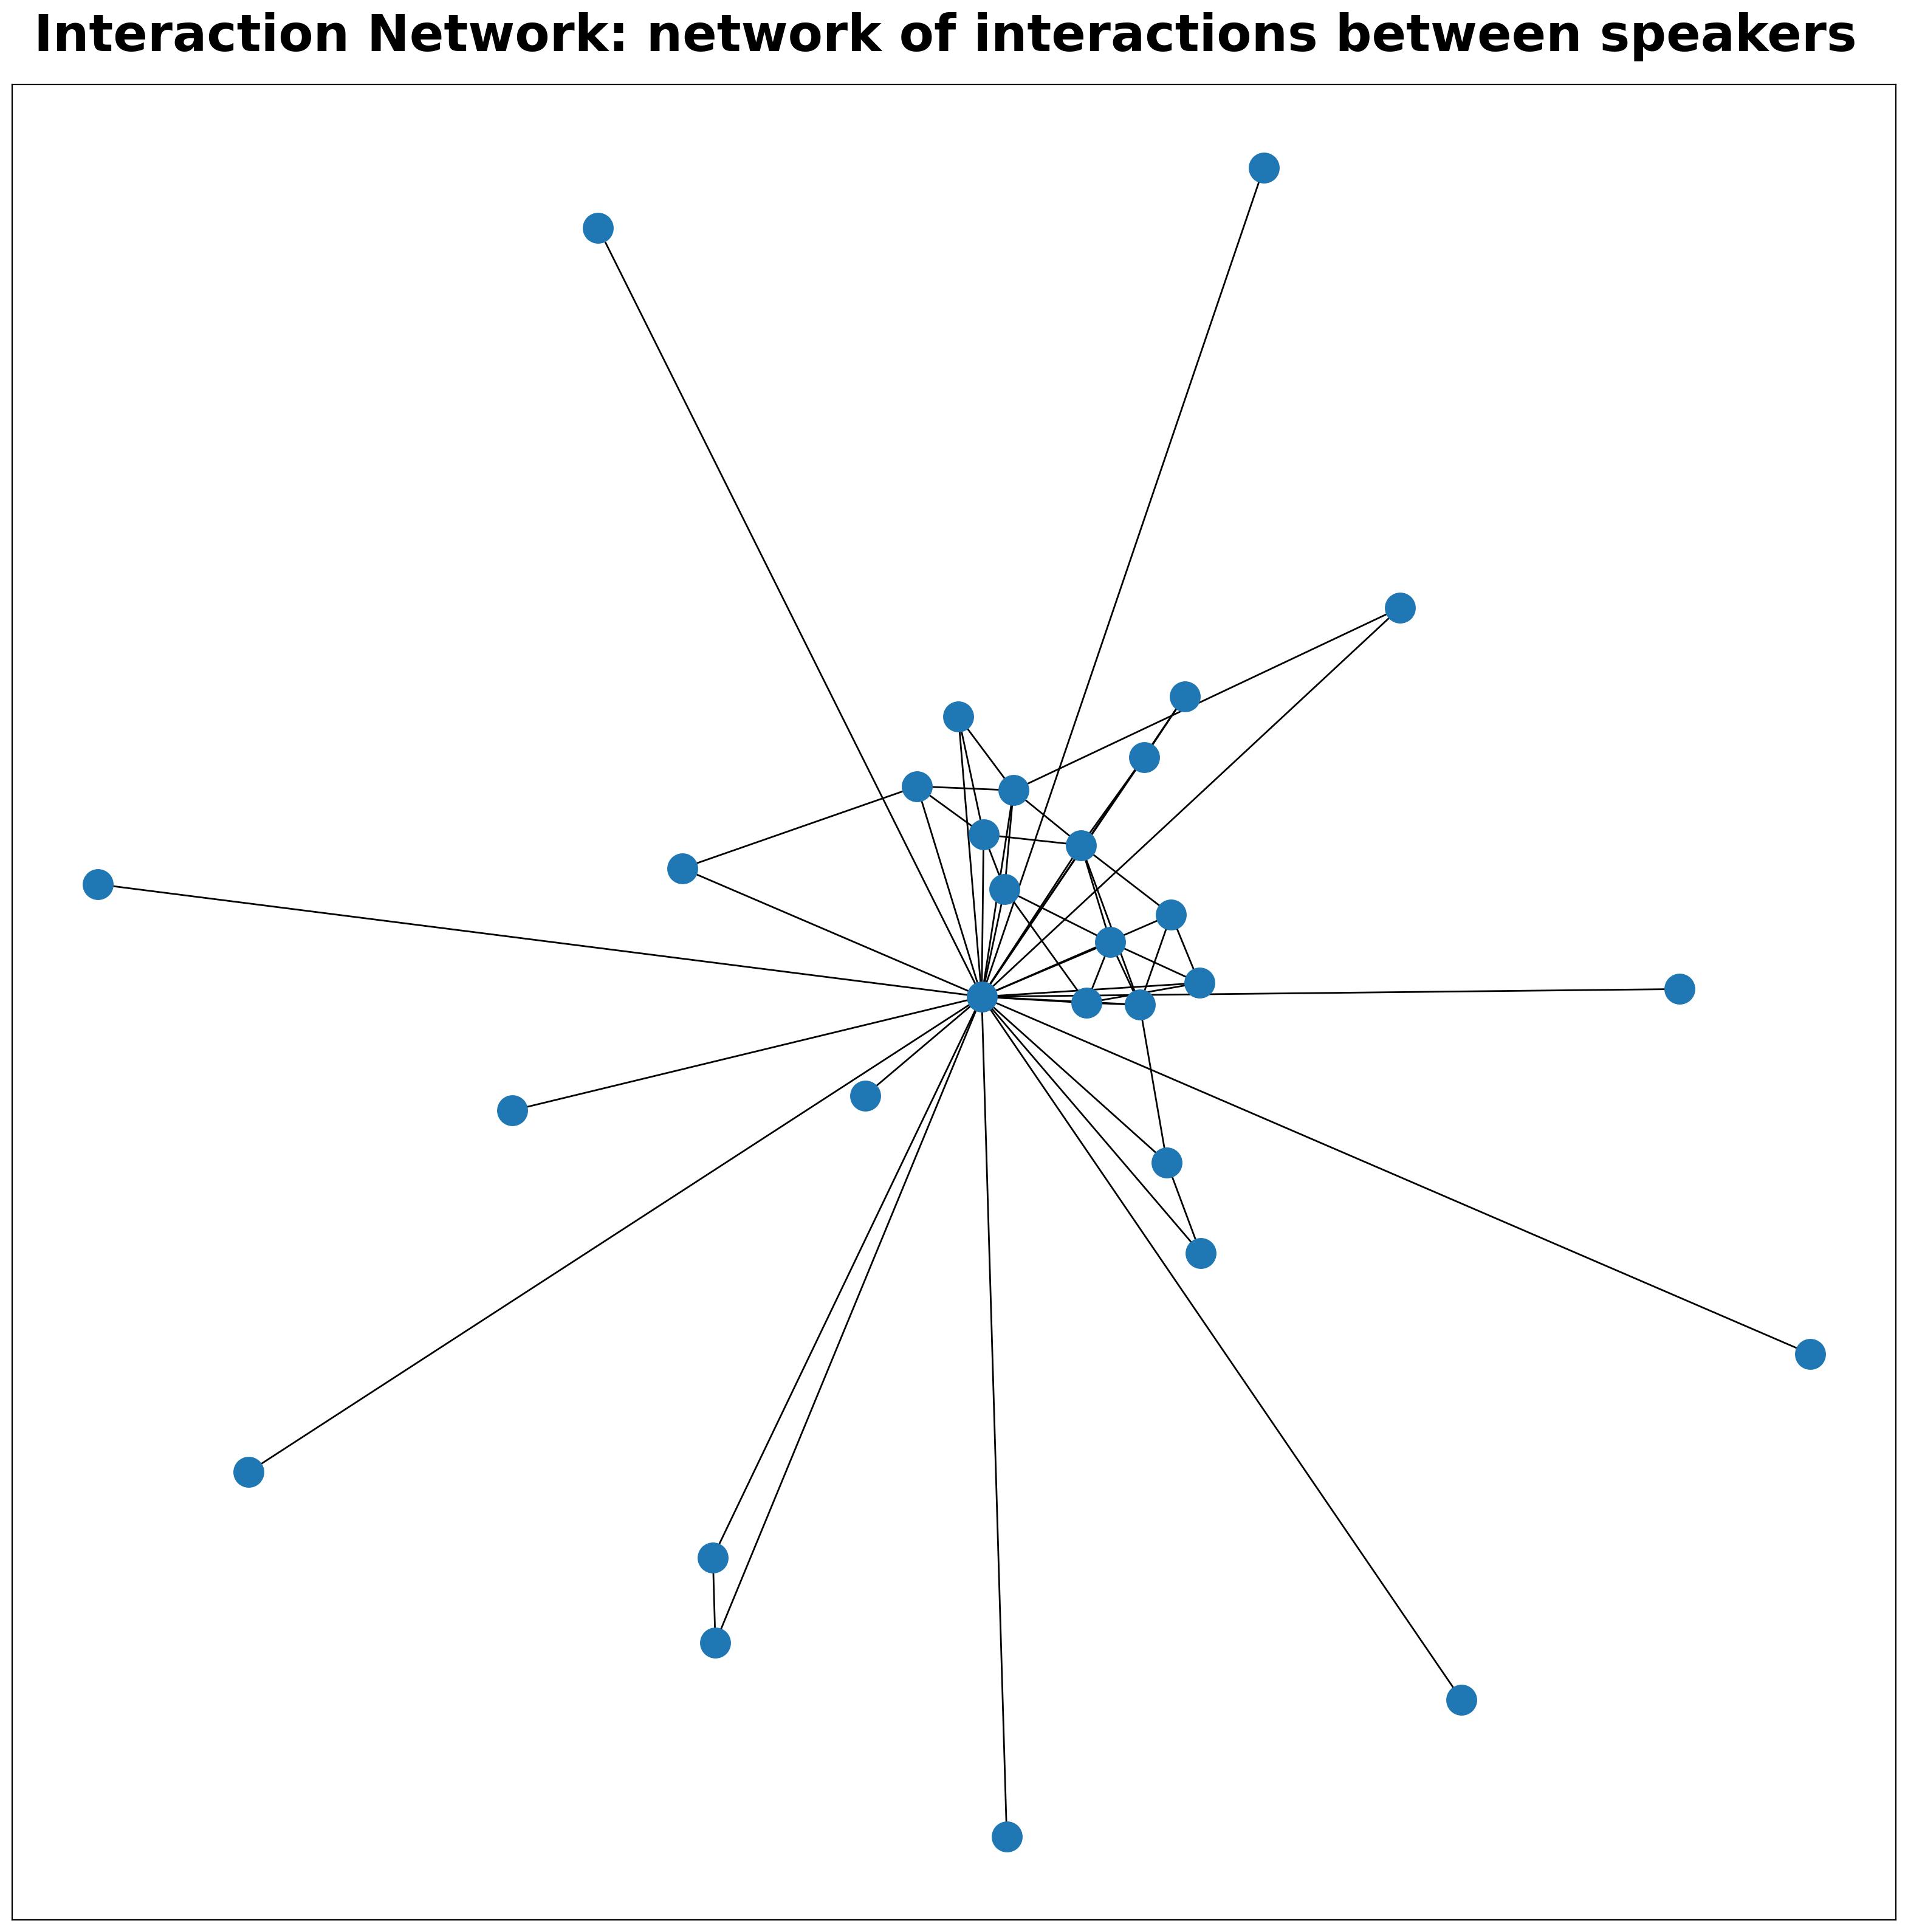

In [120]:
g = full_graphs[cid].graph
print(g.order())
new_figure()
pos = nx.spring_layout(g, seed=1919)
nx.draw_networkx(g, pos, with_labels=False)
plt.title("Interaction Network: network of interactions between speakers ", fontsize=30, fontweight="bold", pad=20)
plt.savefig(f"conv-{cid}-full-graph.png")

In [149]:
!pip install pygraphviz

     |████████████████████████████████| 118 kB 1.3 MB/s eta 0:00:01
Using legacy 'setup.py install' for pygraphviz, since package 'wheel' is not installed.
    Running setup.py install for pygraphviz ... - \ | error
    ERROR: Command errored out with exit status 1:
     command: /home/dev/.virtualenvs/conv/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-wjjdxzrq/pygraphviz_5f0a21123b2f4462bf3fd25529f3895f/setup.py'"'"'; __file__='"'"'/tmp/pip-install-wjjdxzrq/pygraphviz_5f0a21123b2f4462bf3fd25529f3895f/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-28_ji6jz/install-record.txt --single-version-externally-managed --compile --install-headers /home/dev/.virtualenvs/conv/include/site/python3.8/pygraphviz
         cwd: /tmp/pip-install-wjjdxzrq/pygraphviz_5f0a21123b2f4462bf3fd25529f3895f

20


ImportError: requires pygraphviz http://pygraphviz.github.io/

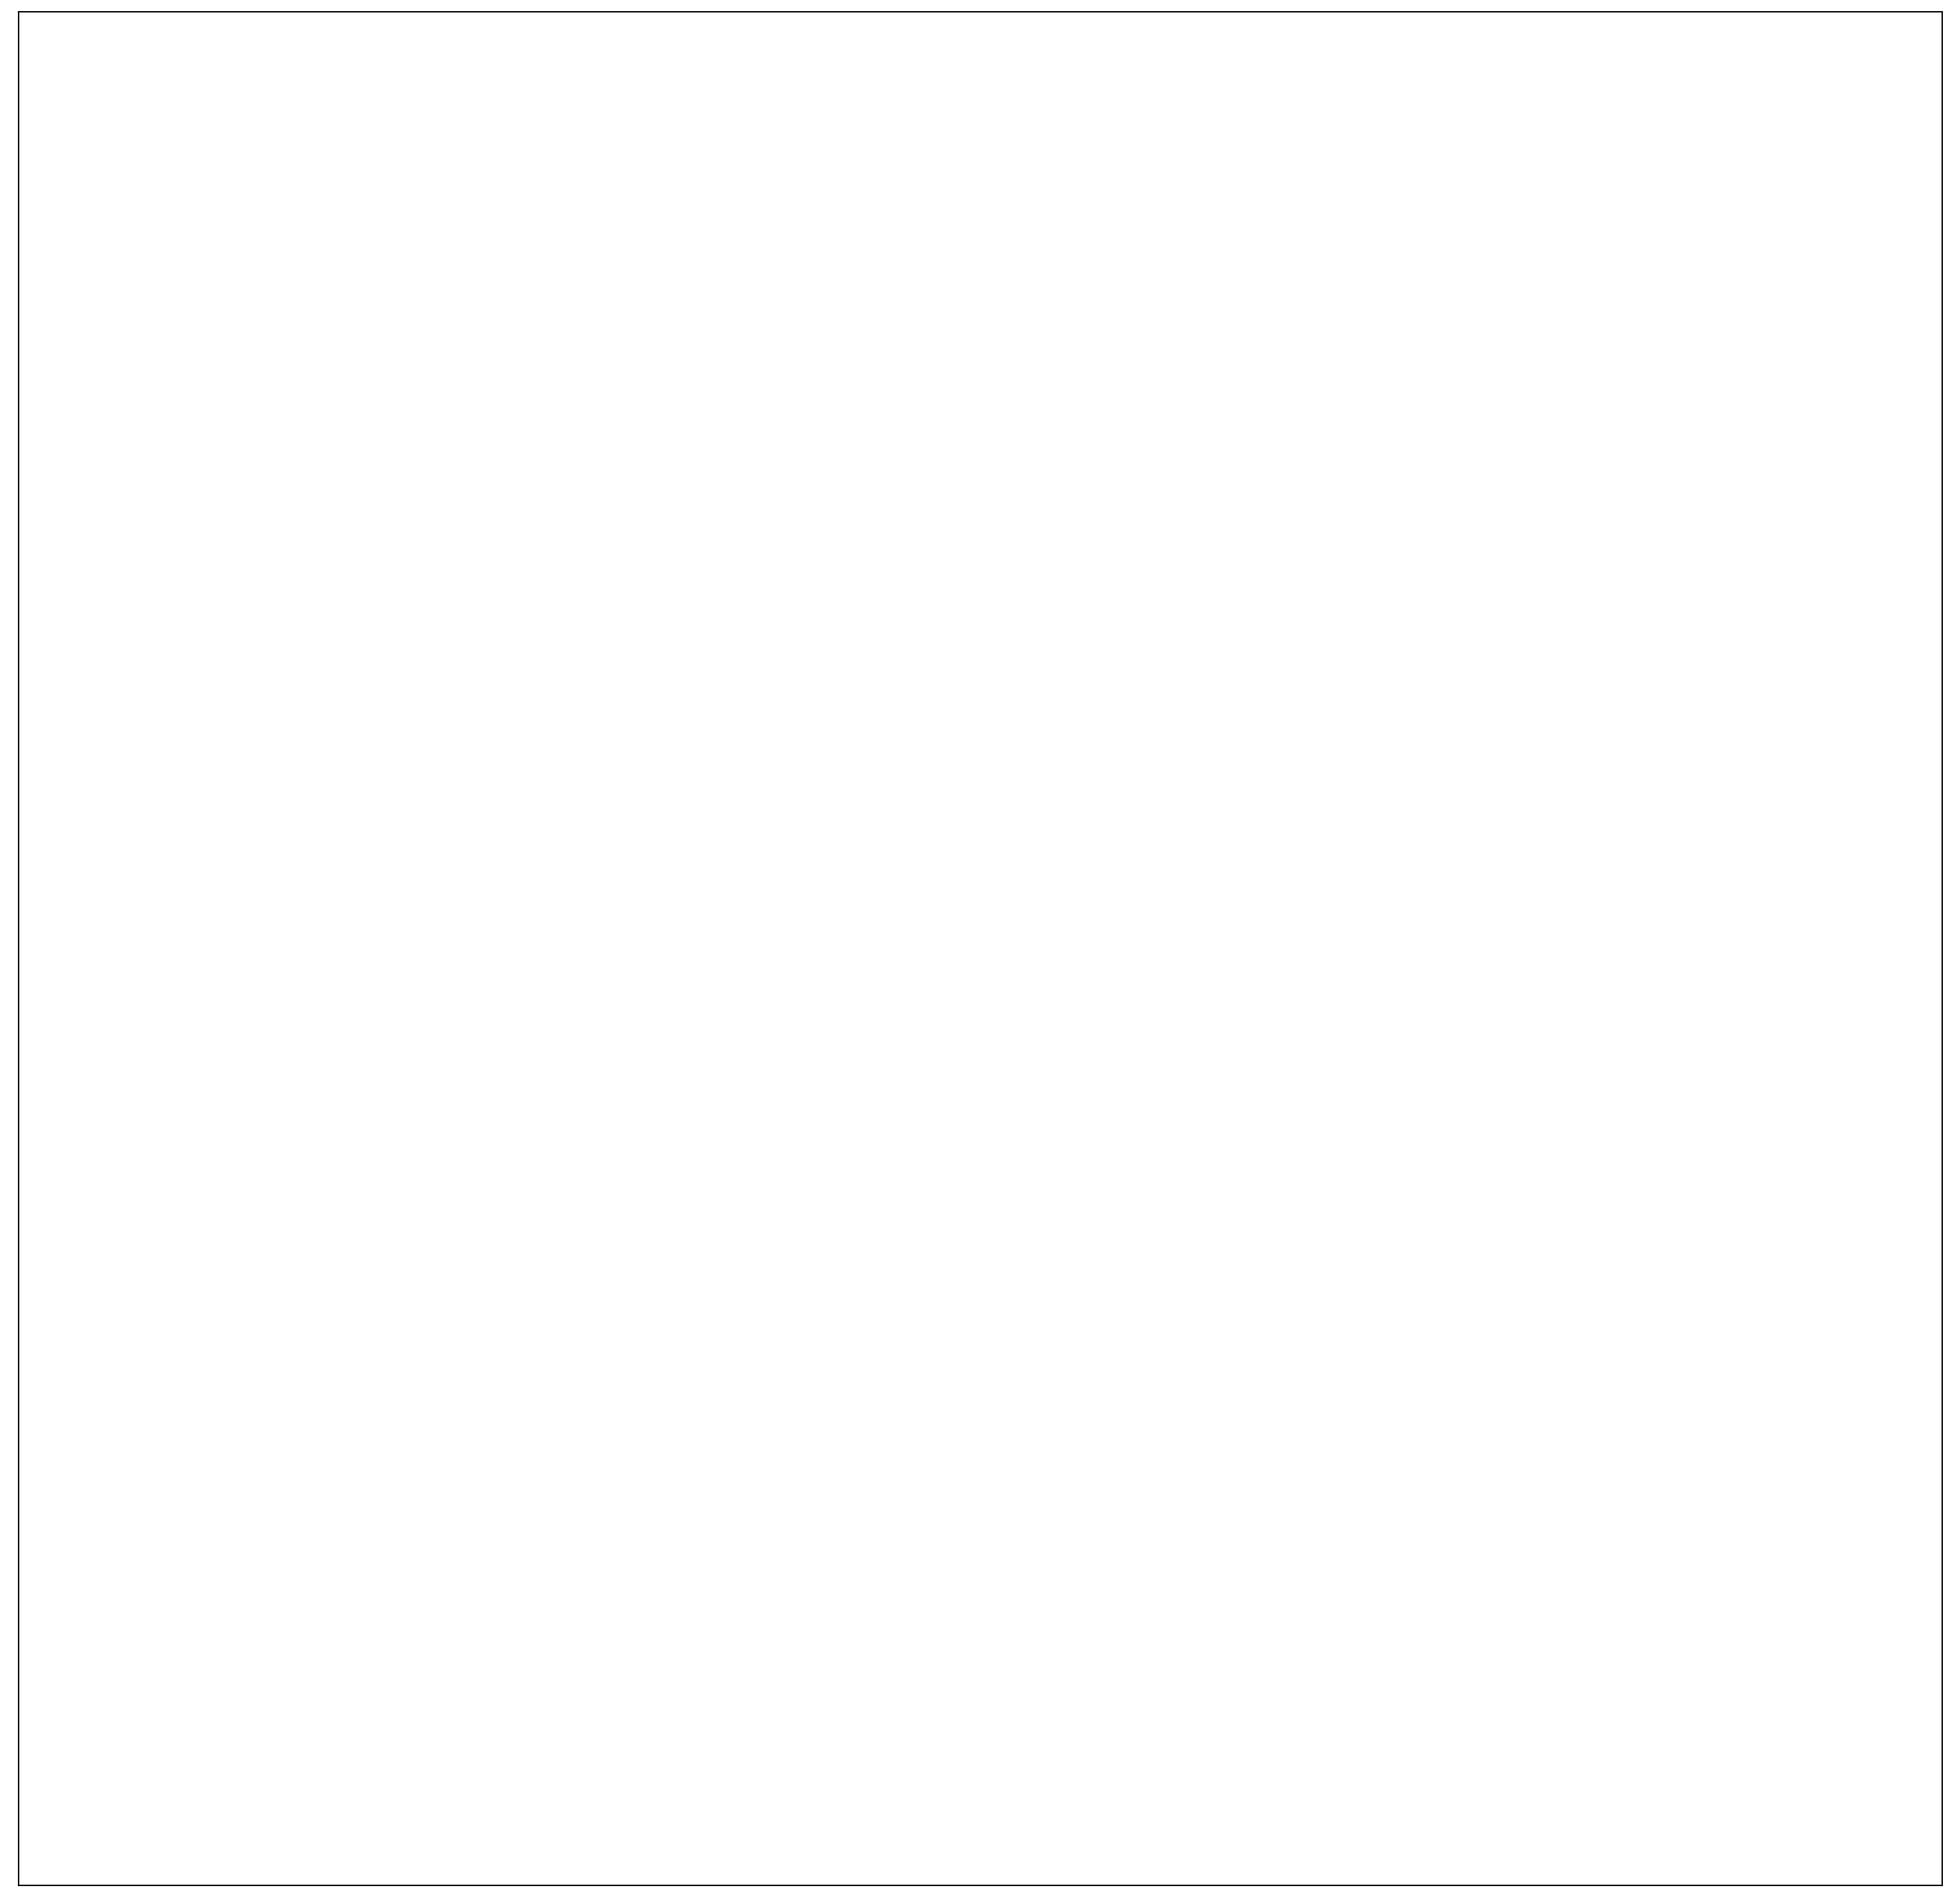

In [148]:
new_figure()
g_core = core_graphs[cid].graph
pos = nx.spring_layout(g_core, seed=1919)
print(g_core.order())

nx.nx_agraph.graphviz_layout(g_core)

# nx.draw_networkx(g_core, pos, with_labels=False)
plt.title("Core-Network: the 2-core graph of the interaction network", fontsize=30, fontweight="bold", pad=20)
plt.savefig(f"conv-{cid}-core-graph.png")


In [245]:
print(cid)
maxcut = maxcut_results[cid]
op, emb, supporters, opposers =\
        maxcut.op, maxcut.embeddings, maxcut.get_supporters(), maxcut.get_complement()

author_labels = get_authors_labels_in_conv(conv)
author_preds = author_predictions[cid]["core"]
y_true, y_pred = align_gs_with_predictions(author_labels, author_preds)
acc = accuracy_score(y_true, y_pred)
print(acc)
if acc < 0.5:
    supporters, opposers = opposers, supporters
    author_preds = get_best_preds(author_labels, author_preds)

true_supporters = [n for n, l in author_labels.items() if l == 1]
true_opposers = [n for n, l in author_labels.items() if l == 0]
unknown_labels = set(author_labels.keys()) - (set(supporters) | set(opposers))
len(author_labels), len(true_opposers), len(true_supporters), len(unknown_labels)

207
0.7368421052631579


(27, 20, 7, 8)

In [246]:
# embeddings = []
# for (a, e) in emb.items():
#     label = 1 if a in supporters else 0 if a in opposers else print("MUZAR")
#     e = e.reshape(-1, 1)
#     dim = len(e)
#     el = np.zeros(e.shape)
#     el[:dim] = e
#     el[-1] = label
#     embeddings.append(el)
#
# a = np.hstack(embeddings)
# a = a.transpose()
# print(a.shape)

In [247]:
#
# np.savetxt(f"conv-{cid2}-embeddings.txt", a)

In [248]:
# supporters, opposers = opposers, supporters

In [249]:
print(sorted(supporters))
print(sorted(true_supporters))
print()
print(sorted(opposers))
print(sorted(true_opposers))

[3, 10, 18, 26, 77, 122, 296, 333, 569, 579, 718]
[18, 57, 77, 122, 531, 569, 718]

[9, 15, 24, 25, 38, 363, 589, 648, 692]
[3, 9, 15, 24, 25, 26, 38, 287, 296, 333, 348, 363, 533, 578, 579, 589, 593, 648, 692, 717]


In [272]:
X = np.vstack([np.array(x) for x in emb.values()])
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
# X_2d = TSNE(n_components=2).fit_transform(X)
X_2d_original = X_2d
X_2d

array([[ 0.97820153, -0.39817999],
       [ 0.58395946,  0.91306872],
       [-0.87766779,  0.32511637],
       [-0.82502797,  0.46638389],
       [-0.61692874, -0.66659654],
       [-0.91663511,  0.07286315],
       [ 1.03652721, -0.25387737],
       [ 1.07084201, -0.10817492],
       [ 1.06622196, -0.13508371],
       [-0.91540227,  0.10327668],
       [ 1.08255225,  0.01618264],
       [-0.90212958,  0.21912666],
       [-0.34429794, -0.85651759],
       [ 0.58391705,  0.9130932 ],
       [-0.41783081, -0.81794712],
       [ 1.08174856, -0.00333212],
       [-0.91653647,  0.07650023],
       [-0.91671854,  0.06931641],
       [ 1.0820629 ,  0.00326316],
       [-0.91685773,  0.06151824]])

In [273]:
# np.random.normal(2*abs(X_2d),X_2d.shape)
# add noise

In [274]:
def compute_unit(v: np.ndarray) -> np.ndarray:
    return v / np.linalg.norm(v)

def compute_unit_average(a: np.ndarray) -> np.ndarray:
    units = np.vstack([compute_unit(v) for v in a])
    m = np.median(units, axis=0)
    return compute_unit(m)
    # return compute_unit(np.sum(a, axis=0))

def rotate_2d(v: np.ndarray,diameter: float) -> np.ndarray:
    direction = np.sign(diameter)
    cos_z = 1 - abs(diameter)
    z = np.arccos(cos_z)
    sin_z = np.sin(z)
    rot_x = (v[0] * cos_z) - (v[1] * sin_z * direction)
    rot_y = (v[0] * sin_z * direction) + (v[1] * cos_z)
    return compute_unit(np.array([rot_x, rot_y]))



def get_degrees_range(center: np.ndarray, diameter: float) -> Tuple[float, float]:
    base_angle = np.array([1, 0])
    cos_angle = cosine(center, base_angle)
    direction = np.sign(1- cos_angle)
    print(cos_angle)
    print(np.arccos(1 - cosine(center, base_angle)))
    center_angle = np.rad2deg(np.arccos(1 - cosine(center, base_angle)))
    if direction < 0:
        center_angle = 360 - center_angle
    print(center_angle)
    diff_angle = np.rad2deg(np.arccos(1- diameter))
    upper = center_angle + diff_angle
    lower = center_angle - diff_angle
    return (lower, upper)

[0.82355167 0.21943823]
1.9966917823015236
3.0602287382455224
184.66180895388644
4.8202093361204845e-06
0.003104903608335843
0.17789787255258419


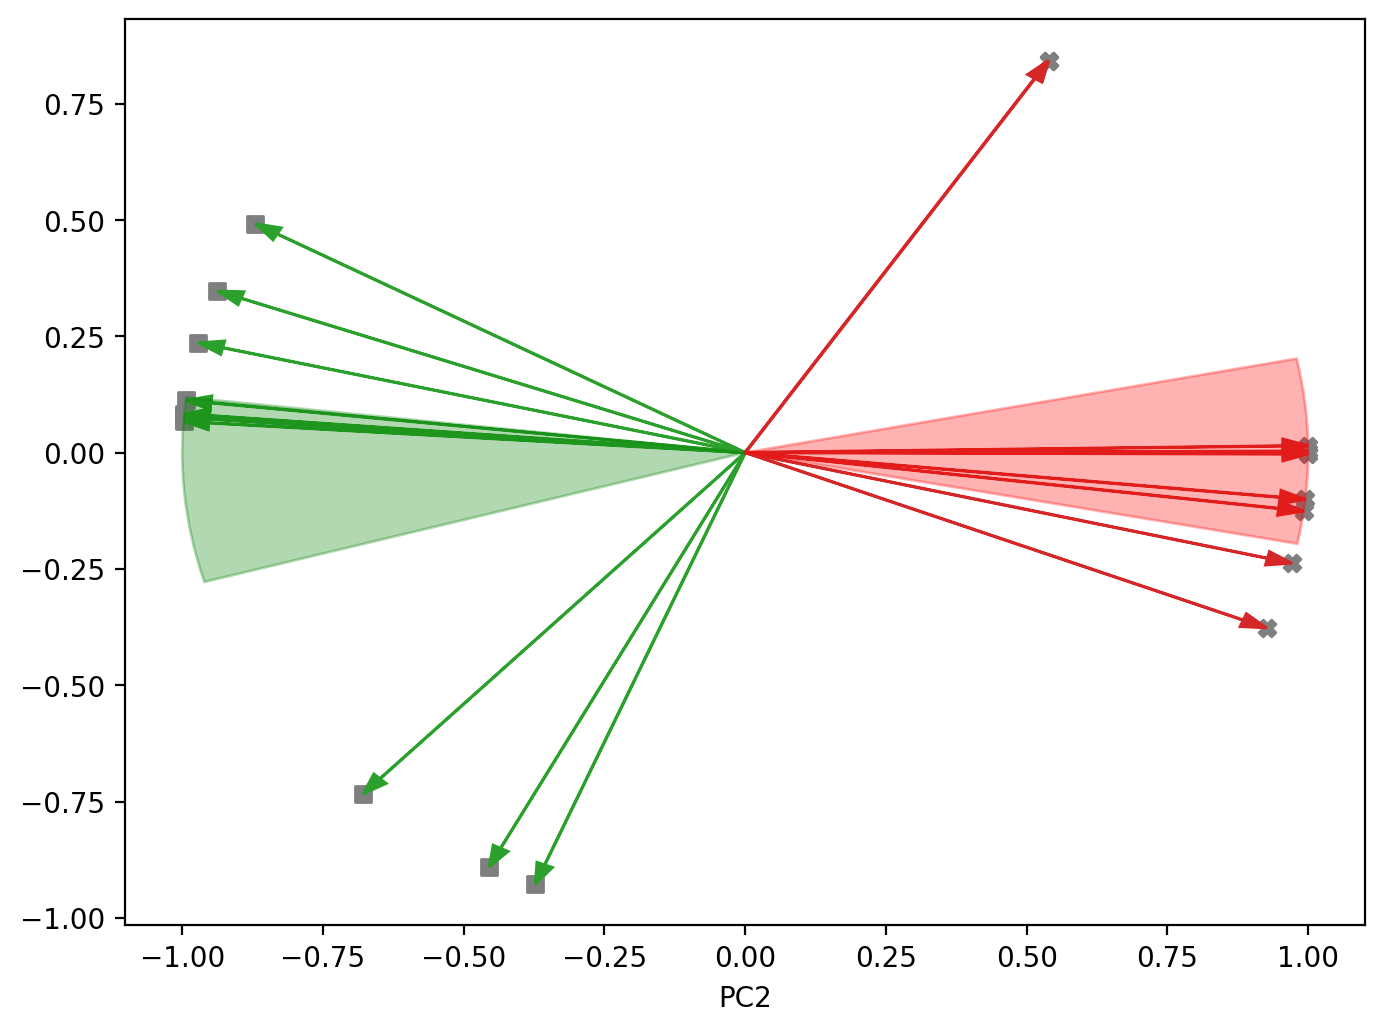

In [276]:
# plt.figure(figsize=(8,6))
# new_figure()
try:
    global fig
    pylab.close(fig)
except NameError:
    pass
fig = pylab.figure(figsize=(8, 6), dpi=200)
# fig.gca().axes.get_xaxis().set_ticks([])
# fig.gca().axes.get_yaxis().set_ticks([])

print(pca.explained_variance_)
nodes = emb.keys()
tp_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in supporters]
fn_supporters_indices = [i for i, n in enumerate(nodes) if n in true_supporters and n in opposers]
tp_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in opposers]
fn_opposers_indices = [i for i, n in enumerate(nodes) if n in true_opposers and n in supporters]
unlabeled_supporters = [i for i, n in enumerate(nodes) if n not in author_labels and n in supporters]
unlabeled_opposers = [i for i, n in enumerate(nodes) if n not in author_labels and n in opposers]

op_index = [i for i, n in enumerate(nodes) if n == op]

# plt.scatter(X_2d[tp_supporters_indices, 0], X_2d[tp_supporters_indices, 1], color='g', marker='+')
# plt.scatter(X_2d[fn_supporters_indices, 0], X_2d[fn_supporters_indices, 1], color='g', marker='x')
# plt.scatter(X_2d[tp_opposers_indices, 0], X_2d[tp_opposers_indices, 1], color='r', marker='x')
# plt.scatter(X_2d[fn_opposers_indices, 0], X_2d[fn_opposers_indices, 1], color='r', marker='+')
# plt.scatter(X_2d[unlabeled_supporters, 0], X_2d[unlabeled_supporters, 1], color='grey', marker='+')
# plt.scatter(X_2d[unlabeled_opposers, 0], X_2d[unlabeled_opposers, 1], color='grey', marker='x')

# plt.scatter(X_2d[tp_supporters_indices, 0], X_2d[tp_supporters_indices, 1], color='g', marker='s')
# plt.scatter(X_2d[fn_supporters_indices, 0], X_2d[fn_supporters_indices, 1], color='r', marker='^')
# plt.scatter(X_2d[tp_opposers_indices, 0], X_2d[tp_opposers_indices, 1], color='r', marker='^')
# plt.scatter(X_2d[fn_opposers_indices, 0], X_2d[fn_opposers_indices, 1], color='g', marker='s')
# plt.scatter(X_2d[unlabeled_supporters, 0], X_2d[unlabeled_supporters, 1], color='g', marker='s')
# plt.scatter(X_2d[unlabeled_opposers, 0], X_2d[unlabeled_opposers, 1], color='r', marker='^')

# plt.scatter([X_2d[op_index, 0]], [X_2d[op_index, 1]], color='b', marker='o')
# add arrows
# X_2d = np.vstack([compute_unit(v) for v in X_2d])

positives = tp_supporters_indices + fn_opposers_indices + unlabeled_supporters
negatives = tp_opposers_indices + fn_supporters_indices + unlabeled_opposers


plt.scatter(X_2d[positives, 0], X_2d[positives, 1], color="tab:grey", marker='s')
plt.scatter(X_2d[negatives, 0], X_2d[negatives, 1], color="tab:grey", marker='X')


for i in positives:
    plt.arrow(0, 0, X_2d[i, 0], X_2d[i, 1], color='tab:green', length_includes_head=True, head_width=0.03)

for i in negatives:
    plt.arrow(0, 0, dx=X_2d[i, 0], dy=X_2d[i, 1], color='tab:red', length_includes_head=True, head_width=0.03)

diameter = 0.02
avg_positive = compute_unit_average(X_2d[positives])
support_upper = rotate_2d(avg_positive, diameter)
support_lower = rotate_2d(avg_positive, -diameter)

avg_negative = compute_unit_average(X_2d[negatives])
oppose_upper = rotate_2d(avg_negative, diameter)
oppose_lower = rotate_2d(avg_negative, -diameter)

# plt.arrow(0, 0, avg_positive[0], avg_positive[1], color='black', length_includes_head=True, head_width=0.03)
# plt.arrow(0, 0, support_upper[0], support_upper[1], ls='--', color='black', length_includes_head=True, head_width=0.03)
# plt.arrow(0, 0, support_lower[0], support_lower[1], ls='--', color='black', length_includes_head=True, head_width=0.03)
# plt.arrow(0, 0, avg_negative[0], avg_negative[1], color='black', length_includes_head=True, head_width=0.03)
# plt.arrow(0, 0, oppose_upper[0], oppose_upper[1], ls='--', color='black', length_includes_head=True, head_width=0.03)
# plt.arrow(0, 0, oppose_lower[0], oppose_lower[1], ls='--', color='black', length_includes_head=True, head_width=0.03)


pos_lower, pos_upper = get_degrees_range(avg_positive, diameter)
pos_wedge = Wedge((0,0), 1, pos_lower, pos_upper, color='green', alpha = 0.3)

neg_lower, neg_upper = get_degrees_range(avg_negative, diameter)
neg_wedge = Wedge((0,0), 1, neg_lower, neg_upper, color='red', alpha = 0.3)

ax = plt.gca().axes
ax.add_patch(pos_wedge)
ax.add_patch(neg_wedge)


fig.gca().axes.set_xlabel("PC1")
fig.gca().axes.set_xlabel("PC2")

plt.savefig(f"angles-conv-{cid}-4forums.png")
# colors = ['b' if i == op else 'g' if i in supporters else 'r' for i in nodes]
# markers = ['o' if i ==op else 'x' if i in supporters else '+' for i in nodes]
# plt.scatter(X_2d[:, 0], X_2d[:, 1], color=colors)
# op_index = [i for i, n  in enumerate(nodes) if n == op][0]

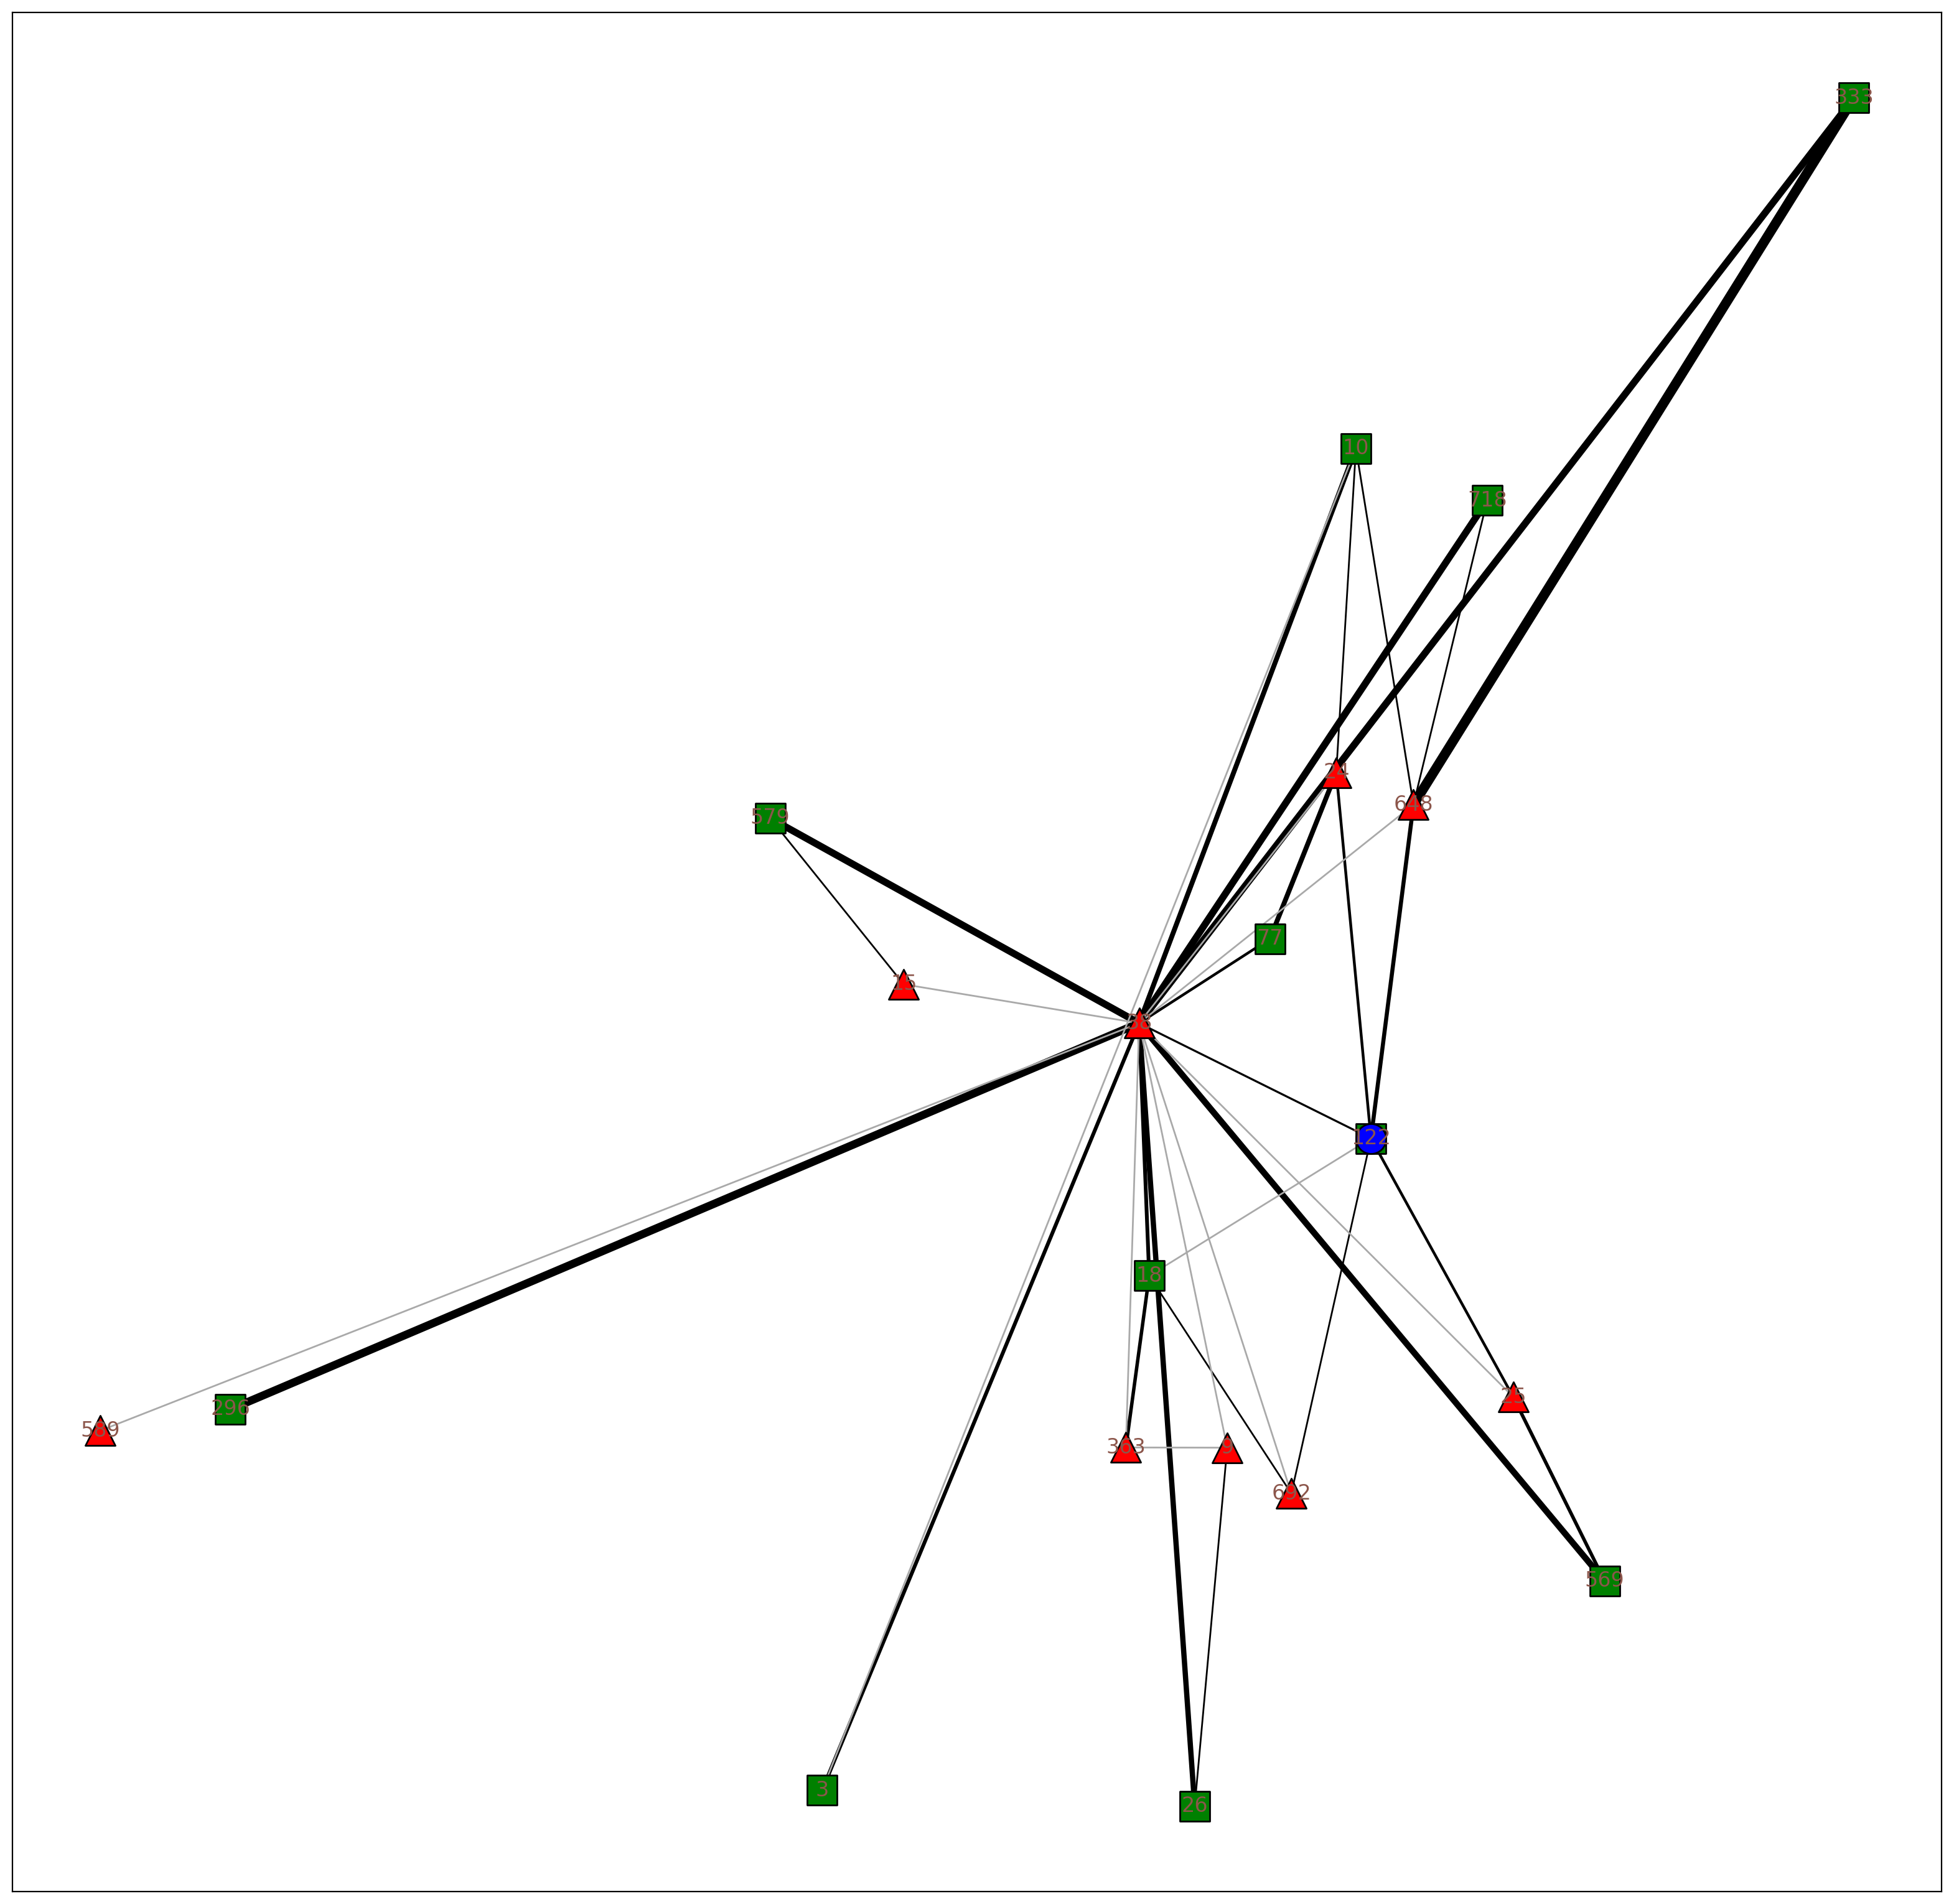

In [265]:
new_figure()
graph = maxcut.graph
# pos = nx.spring_layout(graph, seed=1919)


all_nodes = list(nodes)
tps = [all_nodes[i] for i in tp_supporters_indices]
fns = [all_nodes[i] for i in fn_supporters_indices]
fno = [all_nodes[i] for i in fn_opposers_indices]
tpo = [all_nodes[i] for i in tp_opposers_indices]
unks = [all_nodes[i] for i in unlabeled_supporters]
unko = [all_nodes[i] for i in unlabeled_opposers]
op = [all_nodes[i] for i in op_index]

# nx.draw_networkx_nodes(graph, pos, nodelist=tps, node_color='g', node_shape='s', edgecolors="black")
# nx.draw_networkx_nodes(graph, pos, nodelist=fns, node_color='g', node_shape='^', edgecolors="black")
# nx.draw_networkx_nodes(graph, pos, nodelist=fno, node_color='r', node_shape='s', edgecolors="black")
# nx.draw_networkx_nodes(graph, pos, nodelist=tpo, node_color='r', node_shape='^', edgecolors="black")
# nx.draw_networkx_nodes(graph, pos, nodelist=unks, node_color='grey', node_shape="s", edgecolors="black")
# nx.draw_networkx_nodes(graph, pos, nodelist=unko, node_color='grey', node_shape="^", edgecolors="black")
# nx.draw_networkx_nodes(graph, pos, nodelist=op, node_color='b', node_shape='o', edgecolors="black")

nx.draw_networkx_nodes(graph, pos, nodelist=tps, node_color='g', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fns, node_color='r', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=fno, node_color='g', node_shape='s', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=tpo, node_color='r', node_shape='^', edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unks, node_color='g', node_shape="s", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=unko, node_color='r', node_shape="^", edgecolors="black")
nx.draw_networkx_nodes(graph, pos, nodelist=op, node_color='b', node_shape='o', edgecolors="black")



node_labels = {n: str(n) for n in graph.nodes}
nx.draw_networkx_labels(graph, pos, labels=node_labels, font_color="tab:brown")

# Draw the edges that are in the cut.
edge_weights = [np.log2(graph[e[0]][e[1]]['weight']) for e in maxcut.cut]
nx.draw_networkx_edges(graph, pos, edgelist=maxcut.cut, edge_color="black", width=edge_weights)
#
# # Draw the edges that are not in the cut
leave = [e for e in graph.edges if e not in maxcut.cut]
non_cut_weigths = [np.log2(graph[e[0]][e[1]]['weight']) for e in leave]
nx.draw_networkx_edges(graph, pos, edgelist=leave, edge_color="darkgray")

plt.savefig(f"core-graph-maxcut-{cid}-4forums.png")

## plot tree

In [661]:
from collections import Counter
# remove nodes that occur only once at depth 1

direct_childs = [n.author for n in conv.root.children]
counts = Counter(direct_childs)
counts

Counter({2: 1,
         57: 1,
         38: 2,
         15: 12,
         287: 4,
         333: 3,
         122: 22,
         363: 17,
         18: 11,
         9: 12,
         692: 7,
         77: 17,
         25: 5,
         531: 1,
         579: 3,
         26: 6,
         518: 1,
         578: 1,
         3: 11,
         589: 1,
         296: 2,
         593: 1,
         348: 2,
         24: 7,
         718: 3,
         10: 7,
         648: 8,
         569: 4,
         717: 1,
         533: 1})

In [668]:
authors_to_remove = set([a for a, c in counts.items() if  c == 1])
seen_authors = Counter()
def add_and_get(author):
    seen_authors[author] += 1
    return seen_authors[author]

nns = {10, 24, 3, 533}
nodes_to_retain = [n for n in conv.root.children if n.author in nns]
len(nodes_to_retain)

26

In [669]:
# prev_children = conv.root.children

In [670]:
conv.root.children = nodes_to_retain

In [128]:
post_ids = {172, 173, 174, 184}
nodes_to_retain = [n for n in conv.root.children if n.node_id >= 169]
conv.root.children = nodes_to_retain

In [143]:
labels = {
    "24:173": ("A", "red"),
    "122:178": ("B", "green"),
    "648:179": ("C1", "red"),
    "648:180": ("C2", "red"),
    "122:181": ("D", "green"),
    "648:182": ("E", "red")
}

from anytree.exporter import UniqueDotExporter, DotExporter

def get_name(n):
    return f"{n.author}:{n.node_id}"

def get_attr(n):
    name = get_name(n)
    attrs = labels.get(name, None)
    if attrs is None:
        return "label=_,fontsize=1,shape=circle"

    label, color = attrs
    return f"label={label},shape=circle,style=filled,fillcolor={color}"

exporter = DotExporter(
    conv.root,
    nodeattrfunc=get_attr,
    nodenamefunc=get_name,
    edgeattrfunc=lambda u, v: "dir=back"
)
for line in exporter:
    print(line)
exporter.to_picture("tree2.png")

digraph tree {
    "38:1" [label=_,fontsize=1,shape=circle];
    "24:169" [label=_,fontsize=1,shape=circle];
    "10:170" [label=_,fontsize=1,shape=circle];
    "77:171" [label=_,fontsize=1,shape=circle];
    "10:172" [label=_,fontsize=1,shape=circle];
    "24:173" [label=A,shape=circle,style=filled,fillcolor=red];
    "122:178" [label=B,shape=circle,style=filled,fillcolor=green];
    "648:179" [label=C1,shape=circle,style=filled,fillcolor=red];
    "648:180" [label=C2,shape=circle,style=filled,fillcolor=red];
    "122:181" [label=D,shape=circle,style=filled,fillcolor=green];
    "648:182" [label=E,shape=circle,style=filled,fillcolor=red];
    "122:185" [label=_,fontsize=1,shape=circle];
    "648:186" [label=_,fontsize=1,shape=circle];
    "38:187" [label=_,fontsize=1,shape=circle];
    "648:188" [label=_,fontsize=1,shape=circle];
    "333:189" [label=_,fontsize=1,shape=circle];
    "24:183" [label=_,fontsize=1,shape=circle];
    "3:174" [label=_,fontsize=1,shape=circle];
    "10:175" 

In [770]:
conv

38 - 1
├── 24 - 169
├── 10 - 170
├── 10 - 172
├── 24 - 173
│   └── 122 - 178
│       └── 648 - 179
│           └── 648 - 180
│               └── 122 - 181
│                   ├── 648 - 182
│                   │   └── 122 - 185
│                   │       └── 648 - 186
│                   │           └── 38 - 187
│                   │               └── 648 - 188
│                   │                   └── 333 - 189
│                   └── 24 - 183
├── 3 - 174
│   └── 10 - 175
│       └── 648 - 176
│           └── 10 - 177
└── 533 - 184

In [711]:
for d, n in conv.iter_conversation():
    indent = '  ' * d
    print(f"{indent}author:{n.author}-post_id:{n.node_id}\n{indent}{n.data['text']}")

author:38-post_id:1
http://www.torchx.com/board/index.php?act=ST&f=1&t=20&
I'm having a debate with liberals, and I'm going to need some help. So if anyone is willing to debate, thanks ;-)
  author:24-post_id:169
  The same goes for typing replies like yours, gilligan. I'm trying to help you out by letting you correct your own mistakes, but, since you're so adamant... 
I never said not to have sex if you don't want a child. I said it's stupid and irresponsible for teenagers to freak around as much as they want, and then put the consequences of their actions on someone else. (In this case, the unborn baby.)
  author:10-post_id:170
  Habbit,
Yes you are being made a fool of by a 14 year old
(Decided to respond to some of your less idiotic posts... but I'm having trouble finding them ;) )
Anways.... To the topic
""And you would know considering you're 14 years old? Exactly how many 'relationships' have you gone through that have lasted more than a month?"
- It is very common that a strong

In [677]:
conv_df = conversation_to_dataframe(conv)
conv_df[["author", "parent_id", "data.quote_source_ids", "data.text"]]

,author,parent_id,data.quote_source_ids,data.text
node_id,,,,
1,38,NaN,[],http://www.torchx.com/board/index.php?act=ST&f...
169,24,1.0,[],"The same goes for typing replies like yours, g..."
170,10,1.0,[],"Habbit,\nYes you are being made a fool of by a..."
172,10,1.0,[],"Gilligan,\n(Gives Habbit an excuse to bash ath..."
173,24,1.0,"[170, 171]","SilentPoet-\nNo, it won't. Like I said, the av..."
178,122,173.0,[173],Then I'm certainly glad that all the people yo...
179,648,178.0,[],"Poet,\nIf you were against abortion, you speak..."
180,648,179.0,[],"Poet, \nI agree with you on many points. We ag..."
181,122,180.0,[],"""You and Gilligan look at the issue as an obse..."


In [ ]:
conv

In [327]:
graph.nodes()

NodeView((2, 194, 20, 109, 18, 415, 28, 33, 444))

## Valence

In [79]:
path = "/home/dev/data/stance/valence-results.csv"
valence_df = pd.read_csv(path)

max_score = valence_df["AVG_Score"].max()
min_score = valence_df["AVG_Score"].min()
factor = max_score - min_score

valence_df["norm_score"] = valence_df["AVG_Score"].apply(lambda x: (x - min_score) / factor)

valence_df

,Topic ID,Title,Text,Number Of Posts,Number Of Authors,AVG_Score,STD,norm_score
0,9,Should Evolution be removed from Education ?\n...,Should Evolution be removed from Education ?\n...,57,21,0.400000,0.153326,0.295302
1,10,Do you believe that human and dinosaur tracks ...,Do you believe that human and dinosaur tracks ...,22,10,0.368182,0.136136,0.163758
2,34,Do you support legalized Gay Marriage? \nhttp:...,Do you support legalized Gay Marriage? \nhttp:...,197,49,0.376650,0.147957,0.198767
3,48,Does private gun ownership deter crime ? \nhtt...,Does private gun ownership deter crime ? \nhtt...,60,20,0.480000,0.155778,0.626040
4,49,What did the Founding Fathers intend with the ...,What did the Founding Fathers intend with the ...,102,13,0.384314,0.137017,0.230451
...,...,...,...,...,...,...,...,...
192,7691,Dying Lesbian's Partner Denied Access To Her\n...,Dying Lesbian's Partner Denied Access To Her\n...,18,10,0.455556,0.121208,0.524981
193,7748,"""A person's a person no matter how small""\nHor...","""A person's a person no matter how small""\nHor...",583,29,0.461578,0.148517,0.549880
194,7780,"If guns are banned, people will die. No questi...","If guns are banned, people will die. No questi...",223,22,0.497758,0.150170,0.699455
195,7812,"Whatever, people losing jobs for saying they b...","Whatever, people losing jobs for saying they b...",88,15,0.431818,0.161348,0.426846


In [80]:
valence_df["norm_score"].describe()

count    197.000000
mean       0.445850
std        0.185781
min        0.000000
25%        0.317529
50%        0.433110
75%        0.557331
max        1.000000
Name: norm_score, dtype: float64

In [81]:
records = []
for conv_id, predictions in author_predictions.items():
    conv = convs_by_id[conv_id]
    author_labels = get_authors_labels_in_conv(conv)
    author_preds = predictions.get("core", None)
    if author_preds is None: continue

    y_true, y_pred = align_gs_with_predictions(author_labels, author_preds)
    acc = accuracy_score(y_true, y_pred)

    best_preds = get_best_preds(author_labels, author_preds)
    y_true, y_pred = align_gs_with_predictions(author_labels, best_preds)
    acc_best = accuracy_score(y_true, y_pred)

    r = {
        "conv_id": conv_id,
        "n_authors": len(y_true),
        "acc": acc,
        "acc_best": acc_best
    }
    records.append(r)

acc_df = pd.DataFrame(records)
acc_df

,conv_id,n_authors,acc,acc_best
0,9,9,0.888889,0.888889
1,10,5,0.600000,0.600000
2,34,28,0.642857,0.642857
3,48,15,0.600000,0.600000
4,49,8,0.625000,0.625000
...,...,...,...,...
194,7691,7,0.428571,0.571429
195,7748,26,0.884615,0.884615
196,7780,16,1.000000,1.000000
197,7812,12,0.916667,0.916667


In [82]:
import seaborn as sns

merged_df = acc_df.merge(valence_df, left_on="conv_id", right_on="Topic ID")
merged_df
# new_figure()

,conv_id,n_authors,acc,acc_best,Topic ID,Title,Text,Number Of Posts,Number Of Authors,AVG_Score,STD,norm_score
0,9,9,0.888889,0.888889,9,Should Evolution be removed from Education ?\n...,Should Evolution be removed from Education ?\n...,57,21,0.400000,0.153326,0.295302
1,10,5,0.600000,0.600000,10,Do you believe that human and dinosaur tracks ...,Do you believe that human and dinosaur tracks ...,22,10,0.368182,0.136136,0.163758
2,34,28,0.642857,0.642857,34,Do you support legalized Gay Marriage? \nhttp:...,Do you support legalized Gay Marriage? \nhttp:...,197,49,0.376650,0.147957,0.198767
3,48,15,0.600000,0.600000,48,Does private gun ownership deter crime ? \nhtt...,Does private gun ownership deter crime ? \nhtt...,60,20,0.480000,0.155778,0.626040
4,49,8,0.625000,0.625000,49,What did the Founding Fathers intend with the ...,What did the Founding Fathers intend with the ...,102,13,0.384314,0.137017,0.230451
...,...,...,...,...,...,...,...,...,...,...,...,...
192,7691,7,0.428571,0.571429,7691,Dying Lesbian's Partner Denied Access To Her\n...,Dying Lesbian's Partner Denied Access To Her\n...,18,10,0.455556,0.121208,0.524981
193,7748,26,0.884615,0.884615,7748,"""A person's a person no matter how small""\nHor...","""A person's a person no matter how small""\nHor...",583,29,0.461578,0.148517,0.549880
194,7780,16,1.000000,1.000000,7780,"If guns are banned, people will die. No questi...","If guns are banned, people will die. No questi...",223,22,0.497758,0.150170,0.699455
195,7812,12,0.916667,0.916667,7812,"Whatever, people losing jobs for saying they b...","Whatever, people losing jobs for saying they b...",88,15,0.431818,0.161348,0.426846


<AxesSubplot:xlabel='acc', ylabel='norm_score'>

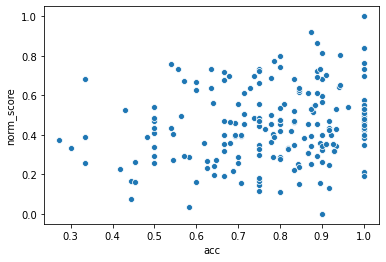

In [91]:
sns.scatterplot(data=merged_df, x="acc", y="norm_score")

In [92]:
from scipy import stats

stats.spearmanr(merged_df["acc"], merged_df["norm_score"])

SpearmanrResult(correlation=0.19712950453957473, pvalue=0.005868512905984206)

In [93]:
stats.pearsonr(merged_df["acc"], merged_df["norm_score"])

(0.20241362151995662, 0.004648483431364058)

In [94]:
merged_df = merged_df[(np.abs(stats.zscore(merged_df["acc"])) < 3)]
merged_df = merged_df[(np.abs(stats.zscore(merged_df["norm_score"])) < 3)]
merged_df

,conv_id,n_authors,acc,acc_best,Topic ID,Title,Text,Number Of Posts,Number Of Authors,AVG_Score,STD,norm_score
0,9,9,0.888889,0.888889,9,Should Evolution be removed from Education ?\n...,Should Evolution be removed from Education ?\n...,57,21,0.400000,0.153326,0.295302
1,10,5,0.600000,0.600000,10,Do you believe that human and dinosaur tracks ...,Do you believe that human and dinosaur tracks ...,22,10,0.368182,0.136136,0.163758
2,34,28,0.642857,0.642857,34,Do you support legalized Gay Marriage? \nhttp:...,Do you support legalized Gay Marriage? \nhttp:...,197,49,0.376650,0.147957,0.198767
3,48,15,0.600000,0.600000,48,Does private gun ownership deter crime ? \nhtt...,Does private gun ownership deter crime ? \nhtt...,60,20,0.480000,0.155778,0.626040
4,49,8,0.625000,0.625000,49,What did the Founding Fathers intend with the ...,What did the Founding Fathers intend with the ...,102,13,0.384314,0.137017,0.230451
...,...,...,...,...,...,...,...,...,...,...,...,...
192,7691,7,0.428571,0.571429,7691,Dying Lesbian's Partner Denied Access To Her\n...,Dying Lesbian's Partner Denied Access To Her\n...,18,10,0.455556,0.121208,0.524981
193,7748,26,0.884615,0.884615,7748,"""A person's a person no matter how small""\nHor...","""A person's a person no matter how small""\nHor...",583,29,0.461578,0.148517,0.549880
194,7780,16,1.000000,1.000000,7780,"If guns are banned, people will die. No questi...","If guns are banned, people will die. No questi...",223,22,0.497758,0.150170,0.699455
195,7812,12,0.916667,0.916667,7812,"Whatever, people losing jobs for saying they b...","Whatever, people losing jobs for saying they b...",88,15,0.431818,0.161348,0.426846


In [95]:
stats.spearmanr(merged_df["acc"], merged_df["norm_score"])

SpearmanrResult(correlation=0.19712950453957473, pvalue=0.005868512905984206)

In [96]:
stats.pearsonr(merged_df["acc"], merged_df["norm_score"])

(0.20241362151995662, 0.004648483431364058)

<AxesSubplot:xlabel='acc', ylabel='norm_score'>

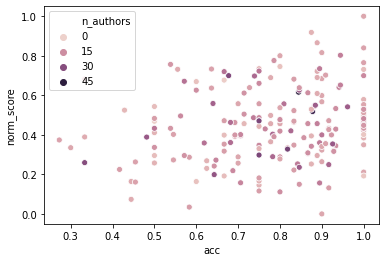

In [97]:
sns.scatterplot(data=merged_df, x="acc", y="norm_score", hue="n_authors")

In [101]:
bins = [0, 0.5, 0.8, 1.1]

for i in range(1, len(bins)):
    prev = bins[i - 1]
    b = bins[i]
    ddf = merged_df[(merged_df["acc"] < b) & (merged_df["acc"] >= prev)]
    print(b, len(ddf), np.mean(ddf["norm_score"]), np.std(ddf["norm_score"]))
    # print(stats.spearmanr(ddf["acc"], ddf["norm_score"]))
    # print(stats.pearsonr(ddf["acc"], ddf["norm_score"]))

0.5 12 0.3200736658496952 0.16122076003083377
0.8 80 0.43223735443459554 0.1776046517337665
1.1 102 0.4724441855890797 0.18695844422722535


In [90]:
valence_df["norm_score"].describe()



count    197.000000
mean       0.445850
std        0.185781
min        0.000000
25%        0.317529
50%        0.433110
75%        0.557331
max        1.000000
Name: norm_score, dtype: float64

In [186]:
bins = [0, 0.5, 0.8, 1.1]

for i in range(1, len(bins)):
    prev = bins[i - 1]
    b = bins[i]
    ddf = merged_df[(merged_df["norm_score"] < b) & (merged_df["norm_score"] >= prev)]
    core_authors = ddf["n_authors"].sum()
    all_authors = ddf["Number Of Authors"].sum()
    core_authors_percentage = core_authors / all_authors
    print(core_authors)
    print(all_authors)
    print(f"bin: {b}, n_convs: {len(ddf)}, core-authors%: {core_authors_percentage}, mean: {np.mean(ddf['acc'])}, std: {np.std(ddf['acc'])}")




1767
2408
bin: 0.5, n_convs: 128, core-authors%: 0.7338039867109635, mean: 0.7566434824327511, std: 0.17329346106390903
851
1162
bin: 0.8, n_convs: 59, core-authors%: 0.7323580034423408, mean: 0.7993205178987258, std: 0.1561252196833403
76
104
bin: 1.1, n_convs: 7, core-authors%: 0.7307692307692307, mean: 0.9154761904761904, std: 0.06659813181690337
